In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import torch
from datetime import datetime, timezone
import logging
import copy

logging.basicConfig(
    level=logging.INFO,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format for the log messages
    handlers=[
        logging.StreamHandler()  # Log to the console
    ]
)

%reload_ext autoreload
%autoreload 2
from data.raw.retrievers.alpaca_markets_retriever import AlpacaMarketsRetriever
from data.raw.retrievers.stooq_retriever import StooqRetriever

from config.constants import *
from data.processed.dataset_creation import DatasetCreator
from data.processed.indicators import *
from data.processed.targets import Balanced3ClassClassification
from data.processed.normalization import ZScoreOverWindowNormalizer, ZScoreNormalizer, MinMaxNormalizer
from data.processed.dataset_pytorch import DatasetPytorch
from modeling.trainer import Trainer
from modeling.evaluate import evaluate_lgb_regressor, evaluate_torch_regressor, evaluate_torch_regressor_multiasset
# from observability.mlflow_integration import log_experiment

from modeling.rl.environment import PortfolioEnvironment
from modeling.rl.state import State
from modeling.rl.agent import RlAgent
from modeling.rl.algorithms.policy_gradient import PolicyGradient
from modeling.rl.actors.actor import RlActor, FullyConnectedBackend, TransformerBackend
from modeling.rl.actors.signal_predictor_actor import SignalPredictorActor
from modeling.rl.actors.high_energy_low_friction_actor import HighEnergyLowFrictionActor
from modeling.rl.actors.xsmom_actor import XSMomActor
from modeling.rl.actors.tsmom_actor import TSMomActor
from modeling.rl.actors.blsw_actor import BLSWActor
from modeling.rl.trajectory_dataset import TrajectoryDataset
from modeling.rl.metrics import MetricsCalculator, DEFAULT_METRICS
from modeling.rl.reward import EstimatedReturnReward
from modeling.rl.loss import SumLogReturnLoss
from modeling.rl.visualization.wealth_plot import plot_cumulative_wealth
from modeling.rl.visualization.position_plot import plot_position_heatmap
from config.experiments.cur_experiment import config

torch.backends.cudnn.benchmark = config.train_config.cudnn_benchmark

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
str(config.data_config.frequency)

'1Day'

In [3]:
retriever = StooqRetriever(download_from_gdrive=False)


In [8]:
def evaluate_signal_predictor(start_date: datetime, end_date: datetime, train_set_last_date: datetime):
    print(f'Running experiment for {start_date} to {end_date} with train set last date {train_set_last_date}')
    
    retrieval_result = retriever.bars(start=start_date, end=end_date)

    dataset_creator = DatasetCreator(
        features=config.data_config.features,
        target=config.data_config.target,
        normalizer=config.data_config.normalizer,
        missing_values_handler=config.data_config.missing_values_handler,
        train_set_last_date=train_set_last_date, 
        cutoff_time=config.data_config.cutoff_time,
        in_seq_len=config.data_config.in_seq_len,
        multi_asset_prediction=config.data_config.multi_asset_prediction,
    )

    X_train, y_train, next_return_train, spread_train, volatility_train, X_test, y_test, next_return_test, spread_test, volatility_test = dataset_creator.create_dataset_numpy(retrieval_result)

    print(X_train.shape, y_train.shape, next_return_train.shape, spread_train.shape, volatility_train.shape, X_test.shape, y_test.shape, next_return_test.shape, spread_test.shape, volatility_test.shape)
    print(np.sqrt(((y_train - np.ones_like(y_train) * 0.5)**2).mean()))
    print(np.sqrt(((y_test - np.ones_like(y_test) * 0.5)**2).mean()))
    
    train_loader = DatasetPytorch(X_train, y_train, learning_task='regression').as_dataloader(
        batch_size=config.train_config.batch_size,
        shuffle=config.train_config.shuffle,
        num_workers=config.train_config.num_workers,
        prefetch_factor=config.train_config.prefetch_factor,
        pin_memory=config.train_config.pin_memory,
        persistent_workers=config.train_config.persistent_workers,
        drop_last=config.train_config.drop_last
    )
    test_loader = DatasetPytorch(X_test, y_test, learning_task='regression').as_dataloader(
        batch_size=config.train_config.batch_size,
        shuffle=config.train_config.shuffle,
        num_workers=config.train_config.num_workers,
        prefetch_factor=config.train_config.prefetch_factor,
        pin_memory=config.train_config.pin_memory,
        persistent_workers=config.train_config.persistent_workers,
        drop_last=config.train_config.drop_last
    )

    model = copy.copy(config.model_config.model)

    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=test_loader,
        loss_fn=config.train_config.loss_fn,
        optimizer=config.train_config.optimizer,
        scheduler=config.train_config.scheduler,
        num_epochs=config.train_config.num_epochs,
        device=config.train_config.device,
        metrics=config.train_config.metrics,
        save_path=config.train_config.save_path,
        early_stopping_patience=config.train_config.early_stopping_patience,
    )

    model, history = trainer.train()

    val_trajectory_loader = TrajectoryDataset(X_test, next_return_test, spread_test, volatility_test, trajectory_length=10).as_dataloader(
        batch_size=8, 
        shuffle=False,
        num_workers=8,
        prefetch_factor=4,
        pin_memory=True,
        persistent_workers=True,
        drop_last=True,
    )

    env = PortfolioEnvironment(
        reward_function=EstimatedReturnReward(fee=0.001, spread_multiplier=0.0),
    )

    backend = FullyConnectedBackend(
        n_assets=len(config.data_config.symbol_or_symbols),
        hidden_dim=128,
        num_layers=2, 
        dropout=0.1,
        use_layer_norm=False,
    )

    actor = RlActor(
        model, 
        backend,
        n_assets=len(config.data_config.symbol_or_symbols),
        train_signal_predictor=False, 
        exploration_eps=0.0
    ).to(device)

    signal_predictor_actor = SignalPredictorActor(
        model, 
        trade_asset_count=1,
        train_signal_predictor=False
    ).to(device)

    rl_agent = RlAgent(
        actor, 
        env,
        single_action_per_trajectory=True
    )

    metrics_calculator = MetricsCalculator(
        metrics=DEFAULT_METRICS
    )

    policy_gradient = PolicyGradient(
        rl_agent, 
        None, 
        val_trajectory_loader, 
        metrics_calculator=metrics_calculator,
        optimizer=torch.optim.AdamW(
            [p for p in actor.parameters() if p.requires_grad], 
            lr=1e-3,
            weight_decay=1e-5,
            amsgrad=True),
        scheduler=None,
        loss_fn=SumLogReturnLoss(use_baseline=False),
        num_epochs=10,
        device=device
    )

    epoch_loss, realized_returns_signal_predictor, actions_signal_predictor = policy_gradient.evaluate(signal_predictor_actor)
    return realized_returns_signal_predictor


In [9]:
start_end_last_train_dates = [
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2008, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2007, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2009, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2008, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2010, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2009, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2011, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2010, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2012, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2011, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2013, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2012, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2014, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2013, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2015, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2014, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2016, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2015, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2017, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2016, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2018, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2017, 9, 1, tzinfo=timezone.utc)},
    {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2019, 9, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2018, 9, 1, tzinfo=timezone.utc)},
]

In [10]:
# start_end_last_train_dates = [
#     {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2025, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2007, 9, 1, tzinfo=timezone.utc)},
#     {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2025, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2008, 9, 1, tzinfo=timezone.utc)},
#     {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2025, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2009, 9, 1, tzinfo=timezone.utc)},
#     {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2025, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2010, 9, 1, tzinfo=timezone.utc)},
#     {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2025, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2011, 9, 1, tzinfo=timezone.utc)},
#     {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2025, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2012, 9, 1, tzinfo=timezone.utc)},
#     {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2025, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2013, 9, 1, tzinfo=timezone.utc)},
#     {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2025, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2014, 9, 1, tzinfo=timezone.utc)},
#     {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2025, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2015, 9, 1, tzinfo=timezone.utc)},
#     {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2025, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2016, 9, 1, tzinfo=timezone.utc)},
#     {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2025, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2017, 9, 1, tzinfo=timezone.utc)},
#     {'start': datetime(1999, 6, 1, tzinfo=timezone.utc), 'end': datetime(2025, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2018, 9, 1, tzinfo=timezone.utc)},
# ]

In [11]:
i = 0
realized_returns = evaluate_signal_predictor(
            start_end_last_train_dates[i]['start'], 
            start_end_last_train_dates[i]['end'], 
            start_end_last_train_dates[i]['last_train_date'])

Running experiment for 1999-06-01 00:00:00+00:00 to 2008-09-01 00:00:00+00:00 with train set last date 2007-09-01 00:00:00+00:00


2025-08-18 19:28:27,139 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-18 19:28:30,358 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-18 19:28:30,707 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-18 19:28:30,883 - INFO - Processing AAPL …
2025-08-18 19:28:30,972 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 19:28:30,974 - INFO - Spread has 0 NaNs
2025-08-18 19:28:30,985 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 19:28:30,994 - INFO - Processing AMGN …
2025-08-18 19:28:31,060 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 19:28:31,063 - INFO - Spread has 0 NaNs
2025-08-18 19:28:31,072 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 19:28:31,083 - INFO - Processing AMZN …
2025-08-18 19:28:31,147 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 19:28:31,149 - INFO - Spread has 0 NaNs


(2008, 27, 60, 15) (2008, 27) (2008, 27) (2008, 27) (2008, 27) (191, 27, 60, 15) (191, 27) (191, 27) (191, 27) (191, 27)
0.35246432
0.38802052


2025-08-18 19:28:35,520 - INFO - Epoch 1/20
2025-08-18 19:28:50,662 - INFO - Train Loss: 0.3964      
2025-08-18 19:28:50,663 - INFO - Train Rmse: 0.6200
2025-08-18 19:28:50,665 - INFO - Val   Loss: 0.1478
2025-08-18 19:28:50,666 - INFO - Val   Rmse: 0.3845
2025-08-18 19:28:50,668 - INFO - 
2025-08-18 19:28:50,675 - INFO - Epoch 2/20
2025-08-18 19:28:53,474 - INFO - Train Loss: 0.1836      
2025-08-18 19:28:53,476 - INFO - Train Rmse: 0.4270
2025-08-18 19:28:53,477 - INFO - Val   Loss: 0.1460
2025-08-18 19:28:53,478 - INFO - Val   Rmse: 0.3820
2025-08-18 19:28:53,479 - INFO - 
2025-08-18 19:28:53,485 - INFO - Epoch 3/20
2025-08-18 19:28:56,278 - INFO - Train Loss: 0.1380      
2025-08-18 19:28:56,280 - INFO - Train Rmse: 0.3713
2025-08-18 19:28:56,280 - INFO - Val   Loss: 0.1560
2025-08-18 19:28:56,284 - INFO - Val   Rmse: 0.3950
2025-08-18 19:28:56,284 - INFO - 
2025-08-18 19:28:56,285 - INFO - Epoch 4/20
2025-08-18 19:28:59,098 - INFO - Train Loss: 0.1378      
2025-08-18 19:28:59,09

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0175


In [6]:
realized_returns = []
for i in range(len(start_end_last_train_dates)):
    realized_returns.extend(
        evaluate_signal_predictor(
            start_end_last_train_dates[i]['start'], 
            start_end_last_train_dates[i]['end'], 
            start_end_last_train_dates[i]['last_train_date']))

Running experiment for 1999-06-01 00:00:00+00:00 to 2008-09-01 00:00:00+00:00 with train set last date 2007-09-01 00:00:00+00:00


2025-08-18 17:08:58,314 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-18 17:09:01,121 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-18 17:09:01,550 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-18 17:09:01,690 - INFO - Processing AAPL …
2025-08-18 17:09:01,750 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 17:09:01,751 - INFO - Spread has 0 NaNs
2025-08-18 17:09:01,758 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 17:09:01,766 - INFO - Processing AMGN …
2025-08-18 17:09:01,822 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 17:09:01,824 - INFO - Spread has 0 NaNs
2025-08-18 17:09:01,830 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 17:09:01,841 - INFO - Processing AMZN …
2025-08-18 17:09:01,901 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 17:09:01,901 - INFO - Spread has 0 NaNs


(2008, 27, 60, 15) (2008, 27) (2008, 27) (2008, 27) (2008, 27) (191, 27, 60, 15) (191, 27) (191, 27) (191, 27) (191, 27)


2025-08-18 17:09:05,488 - INFO - Epoch 1/20
2025-08-18 17:09:18,318 - INFO - Train Loss: 0.3776      
2025-08-18 17:09:18,318 - INFO - Train Rmse: 0.6143
2025-08-18 17:09:18,318 - INFO - Val   Loss: 0.2647
2025-08-18 17:09:18,320 - INFO - Val   Rmse: 0.5143
2025-08-18 17:09:18,320 - INFO - 
2025-08-18 17:09:18,325 - INFO - Epoch 2/20
2025-08-18 17:09:21,105 - INFO - Train Loss: 0.3767      
2025-08-18 17:09:21,107 - INFO - Train Rmse: 0.6136
2025-08-18 17:09:21,107 - INFO - Val   Loss: 0.2613
2025-08-18 17:09:21,107 - INFO - Val   Rmse: 0.5111
2025-08-18 17:09:21,110 - INFO - 
2025-08-18 17:09:21,114 - INFO - Epoch 3/20
2025-08-18 17:09:23,865 - INFO - Train Loss: 0.3768      
2025-08-18 17:09:23,865 - INFO - Train Rmse: 0.6136
2025-08-18 17:09:23,867 - INFO - Val   Loss: 0.2678
2025-08-18 17:09:23,867 - INFO - Val   Rmse: 0.5171
2025-08-18 17:09:23,868 - INFO - 
2025-08-18 17:09:23,868 - INFO - Epoch 4/20
2025-08-18 17:09:26,618 - INFO - Train Loss: 0.3780      
2025-08-18 17:09:26,61

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0123
Running experiment for 1999-06-01 00:00:00+00:00 to 2009-09-01 00:00:00+00:00 with train set last date 2008-09-01 00:00:00+00:00


2025-08-18 17:09:52,645 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-18 17:09:55,604 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-18 17:09:55,854 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-18 17:09:56,008 - INFO - Processing AAPL …
2025-08-18 17:09:56,067 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 17:09:56,071 - INFO - Spread has 0 NaNs
2025-08-18 17:09:56,075 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 17:09:56,091 - INFO - Processing AMGN …
2025-08-18 17:09:56,157 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 17:09:56,158 - INFO - Spread has 0 NaNs
2025-08-18 17:09:56,165 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 17:09:56,174 - INFO - Processing AMZN …
2025-08-18 17:09:56,234 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 17:09:56,236 - INFO - Spread has 0 NaNs


(2259, 27, 60, 15) (2259, 27) (2259, 27) (2259, 27) (2259, 27) (192, 27, 60, 15) (192, 27) (192, 27) (192, 27) (192, 27)


2025-08-18 17:10:11,741 - INFO - Train Loss: 0.3791      
2025-08-18 17:10:11,741 - INFO - Train Rmse: 0.6155
2025-08-18 17:10:11,741 - INFO - Val   Loss: 0.3010
2025-08-18 17:10:11,751 - INFO - Val   Rmse: 0.5485
2025-08-18 17:10:11,751 - INFO - 
2025-08-18 17:10:11,756 - INFO - Epoch 2/20
2025-08-18 17:10:14,896 - INFO - Train Loss: 0.3778      
2025-08-18 17:10:14,896 - INFO - Train Rmse: 0.6145
2025-08-18 17:10:14,897 - INFO - Val   Loss: 0.3010
2025-08-18 17:10:14,897 - INFO - Val   Rmse: 0.5484
2025-08-18 17:10:14,898 - INFO - 
2025-08-18 17:10:14,898 - INFO - Epoch 3/20
2025-08-18 17:10:18,066 - INFO - Train Loss: 0.3774      
2025-08-18 17:10:18,067 - INFO - Train Rmse: 0.6142
2025-08-18 17:10:18,068 - INFO - Val   Loss: 0.3010
2025-08-18 17:10:18,069 - INFO - Val   Rmse: 0.5486
2025-08-18 17:10:18,070 - INFO - 
2025-08-18 17:10:18,070 - INFO - Epoch 4/20
2025-08-18 17:10:21,298 - INFO - Train Loss: 0.3794      
2025-08-18 17:10:21,298 - INFO - Train Rmse: 0.6158
2025-08-18 17:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0253
Running experiment for 1999-06-01 00:00:00+00:00 to 2010-09-01 00:00:00+00:00 with train set last date 2009-09-01 00:00:00+00:00


2025-08-18 17:10:49,891 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-18 17:10:52,660 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-18 17:10:52,922 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-18 17:10:53,240 - INFO - Processing AAPL …
2025-08-18 17:10:53,305 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 17:10:53,306 - INFO - Spread has 0 NaNs
2025-08-18 17:10:53,313 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 17:10:53,322 - INFO - Processing AMGN …
2025-08-18 17:10:53,386 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 17:10:53,387 - INFO - Spread has 0 NaNs
2025-08-18 17:10:53,395 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 17:10:53,401 - INFO - Processing AMZN …
2025-08-18 17:10:53,463 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 17:10:53,465 - INFO - Spread has 0 NaNs


(2511, 27, 60, 15) (2511, 27) (2511, 27) (2511, 27) (2511, 27) (192, 27, 60, 15) (192, 27) (192, 27) (192, 27) (192, 27)


2025-08-18 17:11:09,360 - INFO - Train Loss: 0.3797      
2025-08-18 17:11:09,361 - INFO - Train Rmse: 0.6160
2025-08-18 17:11:09,362 - INFO - Val   Loss: 0.2440
2025-08-18 17:11:09,363 - INFO - Val   Rmse: 0.4939
2025-08-18 17:11:09,363 - INFO - 
2025-08-18 17:11:09,366 - INFO - Epoch 2/20
2025-08-18 17:11:12,872 - INFO - Train Loss: 0.3734      
2025-08-18 17:11:12,872 - INFO - Train Rmse: 0.6109
2025-08-18 17:11:12,872 - INFO - Val   Loss: 0.2440
2025-08-18 17:11:12,872 - INFO - Val   Rmse: 0.4935
2025-08-18 17:11:12,876 - INFO - 
2025-08-18 17:11:12,876 - INFO - Epoch 3/20
2025-08-18 17:11:16,385 - INFO - Train Loss: 0.3798      
2025-08-18 17:11:16,389 - INFO - Train Rmse: 0.6161
2025-08-18 17:11:16,390 - INFO - Val   Loss: 0.2440
2025-08-18 17:11:16,390 - INFO - Val   Rmse: 0.4939
2025-08-18 17:11:16,391 - INFO - 
2025-08-18 17:11:16,392 - INFO - Epoch 4/20
2025-08-18 17:11:20,002 - INFO - Train Loss: 0.3783      
2025-08-18 17:11:20,003 - INFO - Train Rmse: 0.6148
2025-08-18 17:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0163
Running experiment for 1999-06-01 00:00:00+00:00 to 2011-09-01 00:00:00+00:00 with train set last date 2010-09-01 00:00:00+00:00


2025-08-18 17:11:36,997 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-18 17:11:39,782 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-18 17:11:40,234 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-18 17:11:40,385 - INFO - Processing AAPL …
2025-08-18 17:11:40,437 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 17:11:40,448 - INFO - Spread has 0 NaNs
2025-08-18 17:11:40,455 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 17:11:40,461 - INFO - Processing AMGN …
2025-08-18 17:11:40,523 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 17:11:40,524 - INFO - Spread has 0 NaNs
2025-08-18 17:11:40,532 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 17:11:40,540 - INFO - Processing AMZN …
2025-08-18 17:11:40,615 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 17:11:40,619 - INFO - Spread has 0 NaNs


(2763, 27, 60, 15) (2763, 27) (2763, 27) (2763, 27) (2763, 27) (192, 27, 60, 15) (192, 27) (192, 27) (192, 27) (192, 27)


2025-08-18 17:11:57,127 - INFO - Train Loss: 0.3745      
2025-08-18 17:11:57,129 - INFO - Train Rmse: 0.6118
2025-08-18 17:11:57,131 - INFO - Val   Loss: 0.2388
2025-08-18 17:11:57,131 - INFO - Val   Rmse: 0.4878
2025-08-18 17:11:57,131 - INFO - 
2025-08-18 17:11:57,137 - INFO - Epoch 2/20
2025-08-18 17:12:01,040 - INFO - Train Loss: 0.3771      
2025-08-18 17:12:01,041 - INFO - Train Rmse: 0.6139
2025-08-18 17:12:01,042 - INFO - Val   Loss: 0.2388
2025-08-18 17:12:01,042 - INFO - Val   Rmse: 0.4884
2025-08-18 17:12:01,044 - INFO - 
2025-08-18 17:12:01,045 - INFO - Epoch 3/20
2025-08-18 17:12:05,068 - INFO - Train Loss: 0.3779      
2025-08-18 17:12:05,068 - INFO - Train Rmse: 0.6146
2025-08-18 17:12:05,068 - INFO - Val   Loss: 0.2388
2025-08-18 17:12:05,071 - INFO - Val   Rmse: 0.4884
2025-08-18 17:12:05,071 - INFO - 
2025-08-18 17:12:05,072 - INFO - Epoch 4/20
2025-08-18 17:12:09,294 - INFO - Train Loss: 0.3771      
2025-08-18 17:12:09,295 - INFO - Train Rmse: 0.6139
2025-08-18 17:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0052
Running experiment for 1999-06-01 00:00:00+00:00 to 2012-09-01 00:00:00+00:00 with train set last date 2011-09-01 00:00:00+00:00


2025-08-18 17:12:41,425 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-18 17:12:44,504 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-18 17:12:44,778 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-18 17:12:44,926 - INFO - Processing AAPL …
2025-08-18 17:12:44,997 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 17:12:44,998 - INFO - Spread has 0 NaNs
2025-08-18 17:12:45,008 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 17:12:45,015 - INFO - Processing AMGN …
2025-08-18 17:12:45,073 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 17:12:45,082 - INFO - Spread has 0 NaNs
2025-08-18 17:12:45,090 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 17:12:45,097 - INFO - Processing AMZN …
2025-08-18 17:12:45,158 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 17:12:45,163 - INFO - Spread has 0 NaNs


(3015, 27, 60, 15) (3015, 27) (3015, 27) (3015, 27) (3015, 27) (193, 27, 60, 15) (193, 27) (193, 27) (193, 27) (193, 27)


2025-08-18 17:13:02,535 - INFO - Train Loss: 0.3764      
2025-08-18 17:13:02,537 - INFO - Train Rmse: 0.6134
2025-08-18 17:13:02,540 - INFO - Val   Loss: 0.2289
2025-08-18 17:13:02,541 - INFO - Val   Rmse: 0.4783
2025-08-18 17:13:02,543 - INFO - 
2025-08-18 17:13:02,553 - INFO - Epoch 2/20
2025-08-18 17:13:06,970 - INFO - Train Loss: 0.3782      
2025-08-18 17:13:06,970 - INFO - Train Rmse: 0.6149
2025-08-18 17:13:06,971 - INFO - Val   Loss: 0.2293
2025-08-18 17:13:06,971 - INFO - Val   Rmse: 0.4788
2025-08-18 17:13:06,972 - INFO - 
2025-08-18 17:13:06,973 - INFO - Epoch 3/20
2025-08-18 17:13:11,637 - INFO - Train Loss: 0.3756      
2025-08-18 17:13:11,638 - INFO - Train Rmse: 0.6127
2025-08-18 17:13:11,639 - INFO - Val   Loss: 0.2271
2025-08-18 17:13:11,640 - INFO - Val   Rmse: 0.4764
2025-08-18 17:13:11,642 - INFO - 
2025-08-18 17:13:11,648 - INFO - Epoch 4/20
2025-08-18 17:13:16,628 - INFO - Train Loss: 0.3773      
2025-08-18 17:13:16,629 - INFO - Train Rmse: 0.6141
2025-08-18 17:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0230
Running experiment for 1999-06-01 00:00:00+00:00 to 2013-09-01 00:00:00+00:00 with train set last date 2012-09-01 00:00:00+00:00


2025-08-18 17:13:47,022 - INFO - crm_us_d.csv has no data prior to 1999-06-01
2025-08-18 17:13:49,840 - INFO - trv_us_d.csv has no data prior to 1999-06-01
2025-08-18 17:13:50,324 - INFO - v_us_d.csv has no data prior to 1999-06-01
2025-08-18 17:13:50,481 - INFO - Processing AAPL …
2025-08-18 17:13:50,556 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 17:13:50,559 - INFO - Spread has 0 NaNs
2025-08-18 17:13:50,566 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 17:13:50,574 - INFO - Processing AMGN …
2025-08-18 17:13:50,657 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 17:13:50,659 - INFO - Spread has 0 NaNs
2025-08-18 17:13:50,668 - INFO - Imputing 79 NaN rows with 0.5 sentinel value
2025-08-18 17:13:50,677 - INFO - Processing AMZN …
2025-08-18 17:13:50,747 - WARNING - 'ask_price' or 'bid_price' column missing; filling spread with 0.
2025-08-18 17:13:50,749 - INFO - Spread has 0 NaNs


(3268, 27, 60, 15) (3268, 27) (3268, 27) (3268, 27) (3268, 27) (189, 27, 60, 15) (189, 27) (189, 27) (189, 27) (189, 27)


2025-08-18 17:14:08,456 - INFO - Train Loss: 0.3775      
2025-08-18 17:14:08,456 - INFO - Train Rmse: 0.6142
2025-08-18 17:14:08,457 - INFO - Val   Loss: 0.2508
2025-08-18 17:14:08,458 - INFO - Val   Rmse: 0.5006
2025-08-18 17:14:08,458 - INFO - 
2025-08-18 17:14:08,463 - INFO - Epoch 2/20
2025-08-18 17:14:13,304 - INFO - Train Loss: 0.3784      
2025-08-18 17:14:13,304 - INFO - Train Rmse: 0.6150
2025-08-18 17:14:13,305 - INFO - Val   Loss: 0.2392
2025-08-18 17:14:13,306 - INFO - Val   Rmse: 0.4890
2025-08-18 17:14:13,306 - INFO - 
2025-08-18 17:14:13,312 - INFO - Epoch 3/20
2025-08-18 17:14:18,490 - INFO - Train Loss: 0.3756      
2025-08-18 17:14:18,494 - INFO - Train Rmse: 0.6127
2025-08-18 17:14:18,494 - INFO - Val   Loss: 0.2346
2025-08-18 17:14:18,496 - INFO - Val   Rmse: 0.4843
2025-08-18 17:14:18,496 - INFO - 
2025-08-18 17:14:18,502 - INFO - Epoch 4/20
2025-08-18 17:14:23,988 - INFO - Train Loss: 0.3757      
2025-08-18 17:14:23,991 - INFO - Train Rmse: 0.6128
2025-08-18 17:

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0319
Running experiment for 1999-06-01 00:00:00+00:00 to 2014-09-01 00:00:00+00:00 with train set last date 2013-09-01 00:00:00+00:00


2025-08-18 17:15:09,291 - INFO - crm_us_d.csv has no data prior to 1999-06-01


KeyboardInterrupt: 

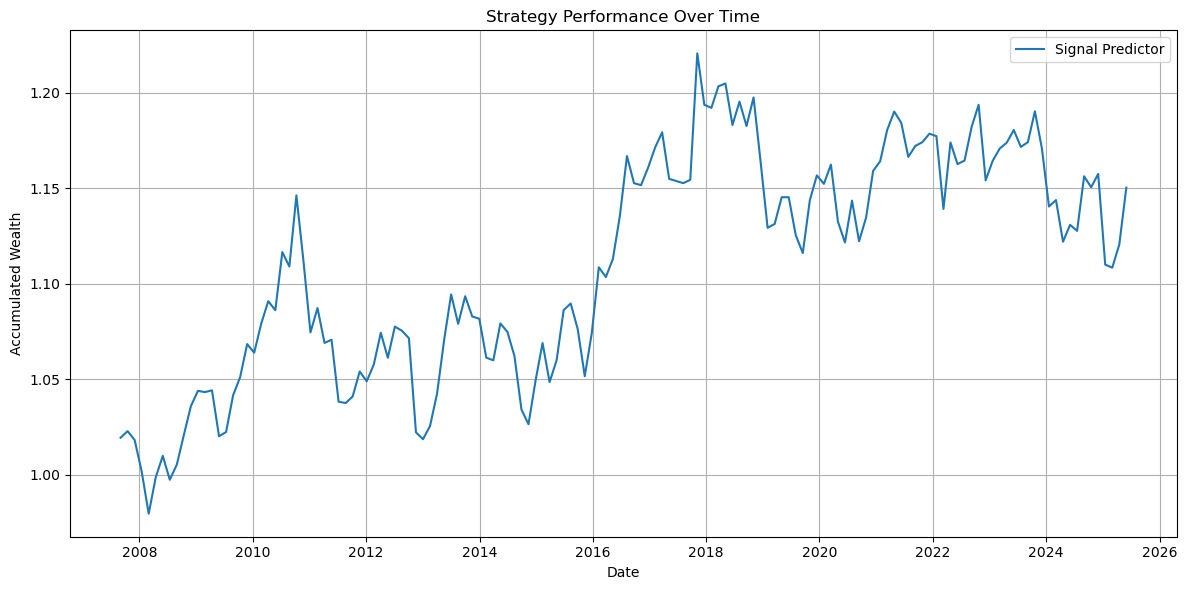

In [12]:
plot_cumulative_wealth(
    returns_dict={
        'Signal Predictor': realized_returns,
    }, 
    start_time=config.data_config.train_set_last_date, 
    end_time=config.data_config.end
)